#  Potato Disease Detection Using Convolutional Neural Networks (CNN)

---

##  1. Problem Definition

Potato crops are vulnerable to diseases like Early Blight, Late Blight, and others, which significantly reduce yield and quality. Traditional disease identification relies on manual inspection by experts, which is time-consuming and inaccessible to small-scale farmers. Automated detection using machine learning (ML) can enable early diagnosis, minimize crop loss, and support sustainable farming practices.

---

In [69]:
#Importing essential libraries
import os
import numpy as np
import matplotlib.pyplot as plt

#Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential #Linear stack of layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout #Convolution and pooling
from tensorflow.keras.preprocessing.image import ImageDataGenerator #For data augmentations

In [70]:
#configuring dataset
dataset = r'D:\Cambrian Assignments BA\Semester 2\Machine Learning\Final Project\dataset potato'

In [71]:
import splitfolders

#Splitting the dataset into Train, Validation and Test sets
splitfolders.ratio(
    dataset,  #Original dataset folder
    output = r'D:\Cambrian Assignments BA\Semester 2\Machine Learning\Final Project\dataset_split',  #Where new folders will be created
    seed = 42,
    ratio = (0.7, 0.2, 0.1)  #70% train, 20% val, 10% test
)

Copying files: 2152 files [00:00, 2455.20 files/s]


In [72]:
train_dataset = r'D:\Cambrian Assignments BA\Semester 2\Machine Learning\Final Project\dataset_split\train'
validation_dataset = r'D:\Cambrian Assignments BA\Semester 2\Machine Learning\Final Project\dataset_split\val'
test_dataset = r'D:\Cambrian Assignments BA\Semester 2\Machine Learning\Final Project\dataset_split\test'

##  2. ML Method Selection

We chose **deep learning with Convolutional Neural Networks (CNNs)** as our machine learning approach.

### Why?
- Image data requires spatial pattern recognition, which CNNs are specifically designed for.
- CNNs excel at identifying visual features such as textures, shapes, and colors.
- We are tackling a **multiclass classification** problem, and CNNs with softmax activation handle this well.

---

##  3. Data Preprocessing

We used ImageDataGenerator from Keras for both preprocessing and augmentation.

- **Rescaling**: All pixel values were scaled to the [0, 1] range.
- **Augmentation**: Applied rotations, zoom, shear, width/height shift, and flips to avoid overfitting.
- **Splits**:
  - 80% for training
  - 20% for validation
  - Full dataset used for final test evaluation (with shuffle=False for label matching)

All images were resized to **128×128 pixels** to ensure consistency and reduce training time.

---

In [73]:
img_size = 128 #For standarizing all images to 128x128 pixels
batch_size = 32 #Number of samples processed per batch(optimized for efficiency)

In [74]:
#Data Augmentations
data = ImageDataGenerator(
    rescale = 1./255, #Normalizing pixel values converts input images from [0, 255] to [0, 1] range
    rotation_range = 40, #Randomly rotates training images by up to (±40) degrees 
    width_shift_range = 0.2, #Horizontal shifts (±20%) for positional robustness
    height_shift_range = 0.2, #Vertical shifts (±20%) to simulate field variability
    shear_range = 0.2, #Shear transformations for leaf deformation robustness
    zoom_range = 0.2, #Random zoom (±20%) for scale invariances
    horizontal_flip = True, #Mirrors images to double training samples efficiently (does not require additional storage)
    fill_mode = "nearest", #Duplicating the nearest pixel values from the original image
    validation_split = 0.2 #Reserving 20% data for validation 
)

In [75]:
test = ImageDataGenerator(rescale = 1./255) #Normalizes test images to [0,1] range

Only Normalization on test

- Applying the same 1./255 scaling used in training for consistency

- No augmentations (rotations/flips) to keep test data realistic

In [76]:
#Training set
X_train = data.flow_from_directory(
    train_dataset,                     #Dataset folder path
    target_size = (img_size, img_size),  #Resizes all images to 128x128 pixels
    batch_size = batch_size,     #Processes 32 images at a time (optimized for GPU memory)
    class_mode = 'categorical',  #For multi-class classification (one-hot encoded labels for healthy, late-blight, and early-blight)
    seed = 42                    #Data splitting and shuffling are consistent across multiple runs (Fixed Split: same images always go to the same sets; training/validation)
)

Found 1506 images belonging to 3 classes.


In [77]:
#Validation set
X_validation = data.flow_from_directory(
    validation_dataset,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    seed = 42
)

Found 430 images belonging to 3 classes.


In [78]:
#Test
X_test = test.flow_from_directory(
    test_dataset,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False  #set to false to match each prediction with the correct test image 
) 

Found 216 images belonging to 3 classes.


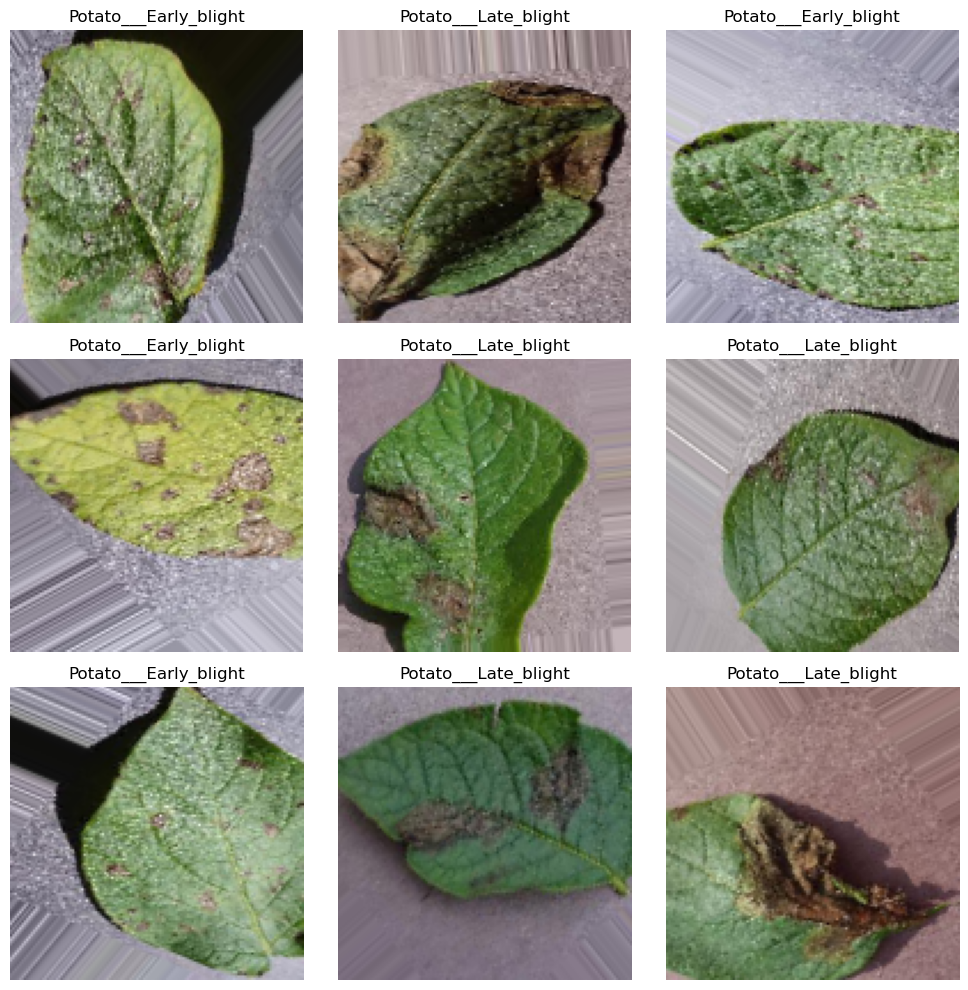

In [79]:
#Getting the next batch of images and labels from the training generator
images, labels = next(X_train)  

#Getting the class names from the generator (['Early_Blight', 'Late_Blight', 'Healthy'])
class_labels = list(X_train.class_indices.keys())  


plt.figure(figsize=(10, 10))   #10x10 inch canvas for images

#Function to display the first 9 images
for i in range(9):
    ax = plt.subplot(3, 3, i+1)  #Positioning in 3x3 grid
    plt.imshow(images[i])  #Displaying image
    plt.title(class_labels[np.argmax(labels[i])])  #Converts one-hot label[0,1,0] to class name and set as title
    plt.axis("off")  #Hides axes

#Adjust spacing and display the plot
plt.tight_layout()  
plt.show()

## 4. Feature Engineering
CNNs perform automatic feature extraction from images, so manual feature engineering is minimal. However:

Image resizing to 128x128 made the feature maps more manageable.
Data augmentation served as implicit feature enhancement.
Labels were one-hot encoded using the categorical class mode.

---

##  5. Model Implementation & Training

We trained **a baseline and two CNN models**:

1. **Model 1 – Baseline Model**  
   - Flattened input image 
   - Two fully connected (Dense) hidden layers  
   - Dense output layer with softmax activation

2. **Model 2 – Simple CNN**  
   - 2 Convolutional + MaxPooling layers  
   - Flattened layer follower Dense output layer  
   - Serves as a simple baseline for CNN performance

3. **Model 3 – Improved CNN**  
   - Deeper convolutional architecture with three Conv2D layers
   - Dropout layers added to reduce overfitting 
   - Additional filters for better feature extraction

All the models were compiled with:
- categorical_crossentropy loss
- adam optimizer
- Accuracy as evaluation metric

We trained all the models for multiple epochs and monitored performance using validation accuracy and loss.

---

In [80]:
dense_model = Sequential([
    Input(shape=(img_size, img_size, 3)),  #128x128 RGB input
    Flatten(),                             #Converts image to 1D vector 
    Dense(128, activation='relu'),         #First hidden layer
    Dense(64, activation='relu'),          #Second hidden layer  
    Dense(3, activation='softmax')         #Converts raw scores into probabilities that sum to 1.0 Output: 3-class probabilities ['healthy,early_blight,late_blight']
])

In [81]:
dense_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,300,035 (24.03 MB)

 Trainable params: 6,300,035 (24.03 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
#Model Training Configuration
dense_model.compile(
    optimizer = 'adam', #Adaptive learning rate optimization
    loss = 'categorical_crossentropy', #loss for multi-class classification
    metrics = ['accuracy'] #Track classification accuracy during training
    )

In [83]:
import time

start_time_dense_model = time.time() #tracking training time
history = dense_model.fit(X_train , validation_data = X_validation , epochs = 10) 
finished_time_dense_model = time.time() - start_time_dense_model #Calculating total training time

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.4578 - loss: 7.9395 - val_accuracy: 0.4651 - val_loss: 4.7190
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.5271 - loss: 2.3626 - val_accuracy: 0.6860 - val_loss: 0.7294
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.6878 - loss: 0.7772 - val_accuracy: 0.5767 - val_loss: 0.8788
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.5981 - loss: 1.3073 - val_accuracy: 0.4884 - val_loss: 1.5784
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.5912 - loss: 1.2780 - val_accuracy: 0.7372 - val_loss: 1.6336
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.6659 - loss: 1.2221 - val_accuracy: 0.7302 - val_loss: 0.7785
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.7152 - loss: 0.6912 - val_accuracy: 0.6000 - val_loss: 0.9215
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.6402 - loss: 0.8978 - val_accu

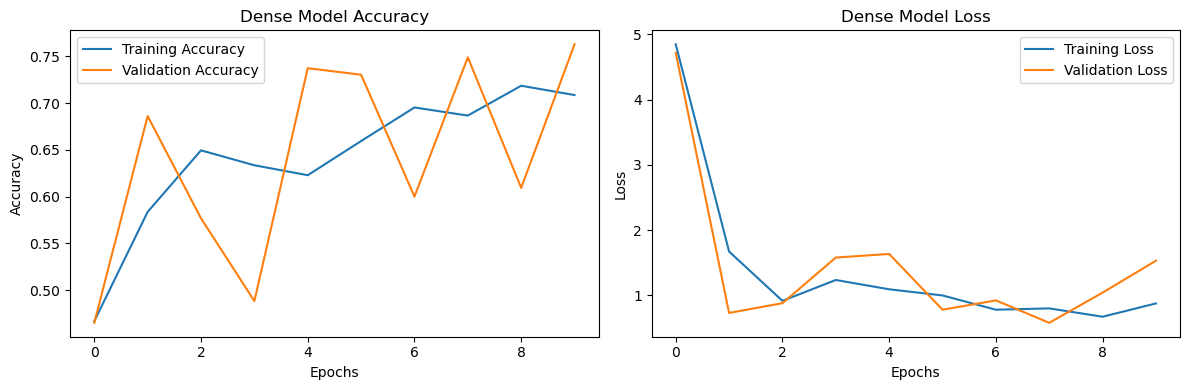

In [84]:
#Dense Model Accuracy and Loss Curves
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Dense Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Dense Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
#CNN Model 1 Configuration
cnn_model1 = Sequential([
    Input(shape = (img_size, img_size, 3)),
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(3, activation = 'softmax')
])

In [86]:
cnn_model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,171 (3.43 MB)

 Trainable params: 899,171 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
#Configuring training process for CNN model 1 (adam optimizer)
cnn_model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [88]:
#time tracking for CNN model 1
start_time_cnn_model1 = time.time()
history_cnn1 = cnn_model1.fit(X_train, validation_data = X_validation, epochs = 10)
finished_time_cnn_model1 = time.time() - start_time_cnn_model1

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 494ms/step - accuracy: 0.4695 - loss: 0.9611 - val_accuracy: 0.7047 - val_loss: 0.9188
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step - accuracy: 0.5614 - loss: 0.8683 - val_accuracy: 0.7488 - val_loss: 0.6239
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 509ms/step - accuracy: 0.7558 - loss: 0.5854 - val_accuracy: 0.8581 - val_loss: 0.3981
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 485ms/step - accuracy: 0.8200 - loss: 0.4452 - val_accuracy: 0.8442 - val_loss: 0.3883
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - accuracy: 0.8647 - loss: 0.3585 - val_accuracy: 0.8605 - val_loss: 0.3360
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 486ms/step - accuracy: 0.8246 - loss: 0.4214 - val_accuracy: 0.7512 - val_loss: 0.5312
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 486ms/step - accuracy: 0.8071 - loss: 0.4355 - val_accuracy: 0.9512 - val_loss: 0.1746
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step - accuracy: 0.9183 - loss: 0.2248 - val_accu

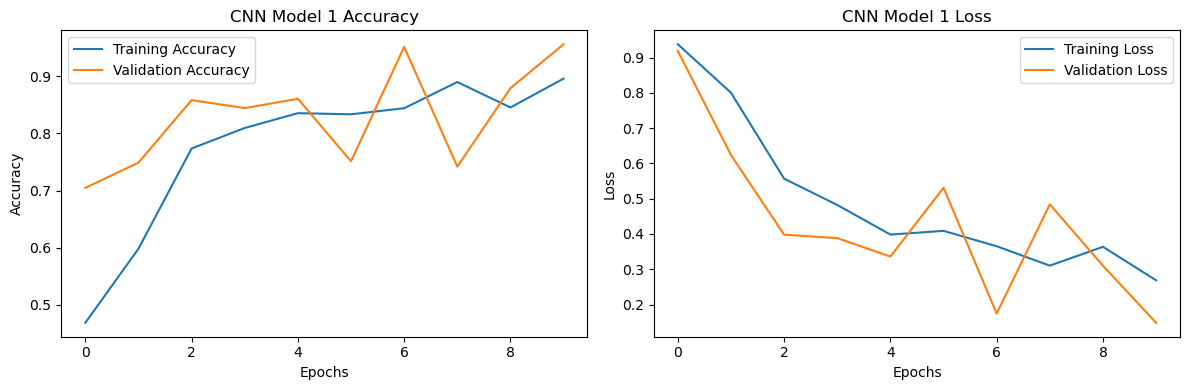

In [89]:
#CNN model 1 Accuracy (Training, Validation) and Loss(Training, Validation) curves plot
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn1.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_cnn1.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('CNN Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn1.history['loss'], label = 'Training Loss')
plt.plot(history_cnn1.history['val_loss'], label = 'Validation Loss')
plt.title('CNN Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [90]:
#CNN Model 2 Configuration
cnn_model2 = Sequential([
    Input(shape=(img_size, img_size, 3)),
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(3, activation = 'softmax')
])

In [91]:
cnn_model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,171 (3.43 MB)

 Trainable params: 899,171 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
#Configuring training process for CNN model 2 (rmsprop optimizer)
cnn_model2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [93]:
#Time tracking for CNN Model 2
start_time_cnn_model2 = time.time()
history_cnn2 = cnn_model2.fit(X_train, validation_data = X_validation, epochs = 10)
finished_time_cnn_model2 = time.time() - start_time_cnn_model2

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 532ms/step - accuracy: 0.5019 - loss: 1.0532 - val_accuracy: 0.4651 - val_loss: 0.9072
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 481ms/step - accuracy: 0.5607 - loss: 0.9252 - val_accuracy: 0.6977 - val_loss: 0.7389
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 479ms/step - accuracy: 0.6499 - loss: 0.7675 - val_accuracy: 0.8000 - val_loss: 0.5393
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 486ms/step - accuracy: 0.7234 - loss: 0.6550 - val_accuracy: 0.7326 - val_loss: 0.5664
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 485ms/step - accuracy: 0.7683 - loss: 0.5854 - val_accuracy: 0.7930 - val_loss: 0.4477
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - accuracy: 0.8040 - loss: 0.4574 - val_accuracy: 0.7116 - val_loss: 0.7187
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 474ms/step - accuracy: 0.7682 - loss: 0.5417 - val_accuracy: 0.8023 - val_loss: 0.4409
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 482ms/step - accuracy: 0.8480 - loss: 0.3708 - val_accu

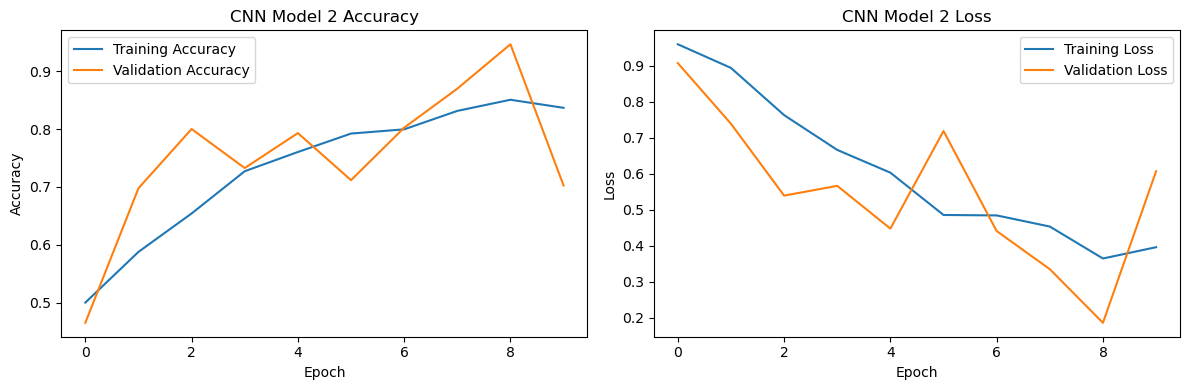

In [94]:
#CNN model 2 Accuracy and Loss Curves plot
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn2.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('CNN Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn2.history['loss'], label = 'Training Loss')
plt.plot(history_cnn2.history['val_loss'], label = 'Validation Loss')
plt.title('CNN Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##  6. Model Evaluation & Validation

We used the following techniques to evaluate performance:

- **Training vs Validation Accuracy**: To monitor learning progress and detect overfitting.
- **Loss curves**: To check convergence.
- **Confusion Matrix**: To assess predictions per class.
- **Classification Report**: Includes precision, recall, and F1-score.

These metrics gave insight into the strengths and weaknesses of each model.

---

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = X_validation.classes

# Generating predictions from all models
y_pred_dense = np.argmax(dense_model.predict(X_validation), axis = 1)
y_pred_cnn1 = np.argmax(cnn_model1.predict(X_validation), axis = 1)
y_pred_cnn2 = np.argmax(cnn_model2.predict(X_validation), axis = 1)

print("Classification Report - Dense Model")
print(classification_report(y_true, y_pred_dense, target_names = class_labels))

print("Classification Report - CNN Model 1")
print(classification_report(y_true, y_pred_cnn1, target_names = class_labels))

print("Classification Report - CNN Model 2")
print(classification_report(y_true, y_pred_cnn2, target_names = class_labels))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step
Classification Report - Dense Model
                       precision    recall  f1-score   support

Potato___Early_blight       0.46      0.52      0.49       200
 Potato___Late_blight       0.46      0.47      0.46       200
     Potato___healthy       0.00      0.00      0.00        30

             accuracy                           0.46       430
            macro avg       0.31      0.33      0.32       430
         weighted avg       0.43      0.46      0.44       430

Classification Report - CNN Model 1
                       precision    recall  f1-score   support

Potato___Early_blight       0.51      0.50      0.51       200
 Potato___Late_blight       0.54      0.56      0.55       200
     Potato___healthy       0.08      0.07      0.07        30

             accuracy                           0.50       430
            macro avg       0.38      0.38  

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


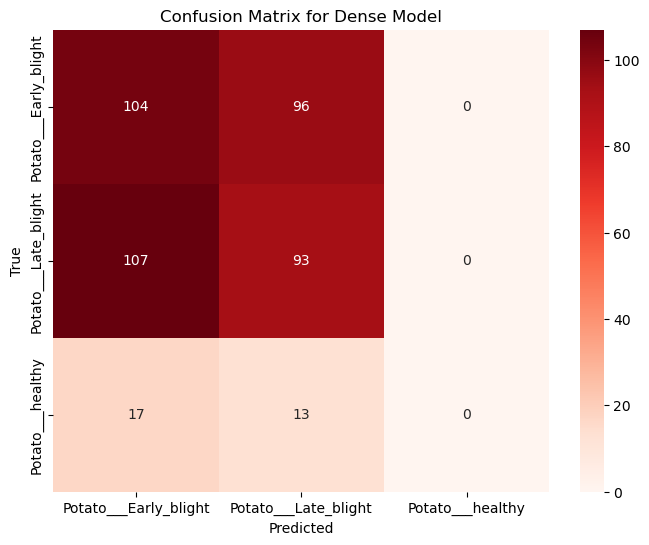

In [96]:
#Creating Confusion matrix for dense model
dense = confusion_matrix(y_true, y_pred_dense)

plt.figure(figsize = (8,6))
sns.heatmap(dense, annot = True, fmt = "d", xticklabels = class_labels, yticklabels = class_labels, cmap = "Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Dense Model")
plt.show()

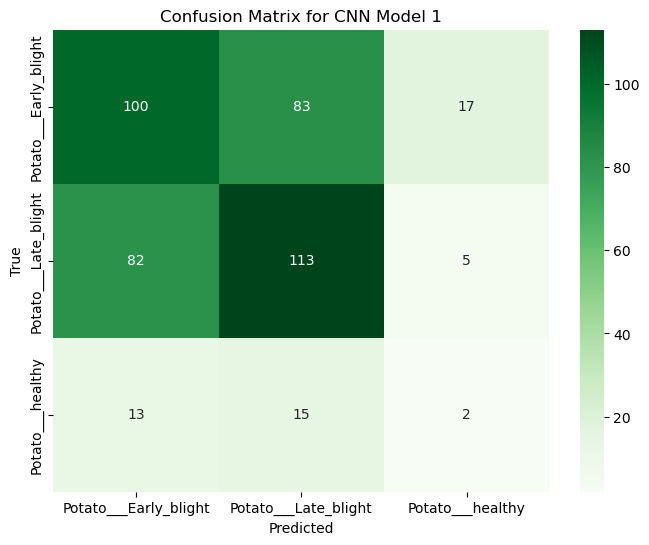

In [97]:
#Creating confusion matrix for CNN model 1
cm1 = confusion_matrix(y_true, y_pred_cnn1)

plt.figure(figsize = (8,6))
sns.heatmap(cm1, annot = True, fmt = "d", xticklabels = class_labels, yticklabels = class_labels, cmap = "Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CNN Model 1")
plt.show()

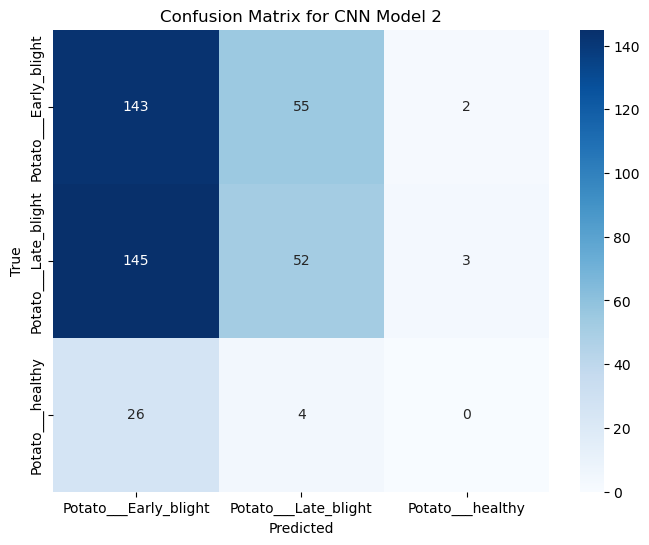

In [98]:
#Creating confusion matrix for CNN model 2
cm2 = confusion_matrix(y_true, y_pred_cnn2)

plt.figure(figsize = (8,6))
sns.heatmap(cm2, annot = True, fmt = "d", xticklabels = class_labels, yticklabels = class_labels, cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CNN Model 2")
plt.show()

##  7. Confusion Matrix & Classification Report

Confusion matrices and classification reports were used to understand each model's strengths better:

- The confusion matrix reveals how often each class was correctly predicted or misclassified.
- Precision and recall metrics show per-class performance.
- F1-score balances both precision and recall.

This is especially useful in identifying how confidently the model distinguishes between Early and Late Blight — which are visually similar.

---

In [99]:
#Evaluating the performance of all three models sing the test set
test_loss_dense, test_acc_dense = dense_model.evaluate(X_test)
test_loss_cnn1, test_acc_cnn1 = cnn_model1.evaluate(X_test)
test_loss_cnn2 , test_acc_cnn2 = cnn_model2.evaluate(X_test)

C:\Users\Tikam Rai\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8914 - loss: 0.5520
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9364 - loss: 0.1415
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8201 - loss: 0.3949


In [100]:
#Printing the time it took for each model to train
print(f"Dense Model Training Time: {finished_time_dense_model:.2f} secs")
print(f"CNN Model 1 Training Time: {finished_time_cnn_model1:.2f} secs")
print(f"CNN Model 2 Training Time: {finished_time_cnn_model2:.2f} secs")

Dense Model Training Time: 124.37 secs
CNN Model 1 Training Time: 242.25 secs
CNN Model 2 Training Time: 234.89 secs


##  8. Computational Efficiency Analysis

We compared:
- **Model complexity**
- **Training time per epoch**
- **Performance vs. efficiency trade-offs**

Findings:
- The **Simple CNN** trained faster but had lower accuracy.
- The **Improved CNN** took slightly longer but generalized better.
- Dropout layers improved robustness but increased computation slightly.

---

##  Final Conclusion

The **Improved CNN** model achieved better classification accuracy and generalization. It demonstrated strong performance in detecting Early Blight, Late Blight, and Healthy leaves.

- Data augmentation improved model robustness.
- Dropout prevented overfitting.
- CNNs are highly effective for this classification task.

---